# Imports

In [1]:
# Imports
import pandas as pd
from time import sleep, time
import http.client
import requests
import yfinance as yf

# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer #Z-score variables
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt
import pandas as pd

Mounted at /content/drive


# Preprocessing, Splitting, and Scaling

## Loading and Preprocessing

In [2]:
data = pd.read_csv("/content/drive/MyDrive/DataScienceProjects/FinancePredictor/data/FinalData.csv")
middle = data.drop(data.columns[0], axis=1) # Making up some columns out of nowhere, idk
#final = middle.drop(middle.columns[0], axis=1) # This deletes the date column
final = middle.drop(columns=["index"])

#final["Target1"] = final["Close"].shift(-1) # need to shift all the values up one to make the predictions for day + 1
final["Target5"] = final["Close"].shift(-1) # using this for predictions 5 days in the future
final = final.dropna(axis = 0)
final[:-1] # Final includes the date, useful for plotting later

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,5DAvg,10DAvg,...,EPS,Current,D/E,ITR,ROE,ROA,BVPS,OCFPS,FCFPS,Target5
19,2020-05-06 00:00:00-04:00,285.762763,286.795458,282.646218,284.813049,2406700,0.0,0,281.451233,282.101013,...,1.89,1.1087,0.5287,2.9291,4.9526,1.6470,38.9629,4.2745,2.7026,281.226196
20,2020-05-07 00:00:00-04:00,285.227903,285.716590,280.792830,281.226196,2601800,0.0,0,281.820050,282.128311,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,282.093018
21,2020-05-08 00:00:00-04:00,282.056128,283.236355,280.027627,282.093018,2337400,0.0,0,282.561377,281.768518,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,286.140839
22,2020-05-11 00:00:00-04:00,281.816434,287.523919,281.226306,286.140839,1865900,0.0,0,283.638348,281.976337,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,281.078735
23,2020-05-12 00:00:00-04:00,286.611055,287.265705,281.032644,281.078735,2264900,0.0,0,283.070367,282.030289,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,278.589172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,2025-03-28 00:00:00-04:00,937.500000,938.750000,926.000000,929.659973,2100500,0.0,0,930.891992,917.782996,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,945.780029
1250,2025-03-31 00:00:00-04:00,922.359985,995.000000,922.039978,945.780029,3102000,0.0,0,934.840002,920.700000,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,954.400024
1251,2025-04-01 00:00:00-04:00,942.419983,957.719971,938.750000,954.400024,2041500,0.0,0,939.668005,926.335004,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,965.080017
1252,2025-04-02 00:00:00-04:00,950.840027,970.890015,950.000000,965.080017,1719900,0.0,0,946.734009,932.438007,...,2.10,1.0444,0.3294,2.8739,5.5709,1.9413,38.4922,1.3945,0.1665,967.080017


## Data Splitting
Split into chunks shown below
Format is Chunk/Train/Val/Test
Best Sizes are 206/130/38/38 and 103/65/19/19

### defining splitting and scaling

Splits into chunks and then minMax scales the data

In [3]:
def splitAndScaleData(chunk_size, train_size, val_size, test_size, final):

  X_train_list, y_train_list = [], []
  X_val_list, y_val_list = [], []
  X_test_list, y_test_list = [], []

  # Assume the last column is your target
  feature_cols = final.columns[1:-1]
  target_col = final.columns[-1]

  # Loop through all 14 chunks
  for i in range(0, len(final), chunk_size):
      chunk = final.iloc[i:i+chunk_size]

      # Make sure the chunk is exactly chunk_size
      if len(chunk) != chunk_size:
          continue  # skip incomplete chunks if any

      # Features and targets
      X_chunk = chunk[feature_cols].values
      y_chunk = chunk[target_col].values

      # Slice the chunk into train/val/test
      X_train_list.append(X_chunk[:train_size])
      y_train_list.append(y_chunk[:train_size])

      X_val_list.append(X_chunk[train_size:train_size+val_size])
      y_val_list.append(y_chunk[train_size:train_size+val_size])

      X_test_list.append(X_chunk[train_size+val_size:])
      y_test_list.append(y_chunk[train_size+val_size:])

  # Stack all segments into final arrays
  X_train = np.vstack(X_train_list)
  y_train = np.hstack(y_train_list)

  X_val = np.vstack(X_val_list)
  y_val = np.hstack(y_val_list)

  X_test = np.vstack(X_test_list)
  y_test = np.hstack(y_test_list)

  # Print shapes to verify
  # print("Train:", X_train.shape, y_train.shape)
  # print("Val:", X_val.shape, y_val.shape)
  # print("Test:", X_test.shape, y_test.shape)

  # want to remove the dates before sending to model
  X_train_less_dates = np.delete(X_train, 1, axis = 1)
  X_val_less_dates = np.delete(X_val, 1, axis = 1)
  X_test_less_dates = np.delete(X_test, 1, axis = 1)

  # Scale the data for the mode
  X_train_scaled = X_scaler.fit_transform(X_train_less_dates)
  X_val_scaled = X_scaler.transform(X_val_less_dates)
  X_test_scaled = X_scaler.transform(X_test_less_dates)

  # reshape into proper array size
  X_train_scaled = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
  X_val_scaled = X_val_scaled.reshape((-1, 1, X_val_scaled.shape[1]))
  X_test_scaled = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

  # reshape into 1D array
  y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
  y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
  y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

  return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled



### usage of splitting

In [4]:
chunk_size = 206
train_size = 130
val_size = 38
test_size = 38

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled = splitAndScaleData(chunk_size, train_size, val_size, test_size, final)

# Model, Change as needed, need to optimize

In [5]:
model = Sequential()
# Need to optimize model, like adding more hidden LSTM layers
model.add(LSTM(512, activation='tanh', return_sequences=True, input_shape=(1, 44)))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Predicting one value: close price in day + 5

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 512)         │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,187,681 (8.35 MB)

 Trainable params: 2,187,681 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.1649 - root_mean_squared_error: 0.4047 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2559
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0414 - root_mean_squared_error: 0.2015 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss

# Testing Model on Unseen Data

## Visualizing the segment buy times.
Green on the graph means the model bought at that time. Red means the model did not buy, and does NOT mean it sold. The model naively sells after 5 trading days.

The average growth over 10 models was: ~1200%

The stock growth using same data was: 167.01%

In [67]:
# grab all values in the test set

# predicted price values for test data - will be in day t + 5
pred_price_scal = model.predict(X_test_scaled)
pred_price = y_scaler.inverse_transform(pred_price_scal).flatten()

# This grabs the CLOSE column for the current day of the test data, so it is day T
X_test = X_scaler.inverse_transform(X_test_scaled[:,0,:]) #convert the current timestep into a 2D array
curr_price = X_test[:, 2] # grab the correct column



diff_price = pred_price - curr_price # difference between future price and current price, if positive we buy

for i in range(len(diff_price)):
  if(diff_price[i] > 0):
    diff_price[i] = 1
  else:
    diff_price[i] = 0

# diff price is now all the days we should "buy"
# loop through all days except last 5,
#   if diffprice is a 1, add day+5 percentage to a list
#   if diffprice is a 0, continue

# deltas will be the decimal percentage gain/loss of each "buy" day
deltas = []

# for i in range(1, len(diff_price) - 5):
#   if(diff_price[i] == 1):
#     deltas.append((actual_price[i + 5] - actual_price[i] )/ actual_price[i]) #calculate the percentage difference and add to price

for seg in range(0, 5): # for each segment in the section
  # then loop through the values in the segment, so seg * test_size to seg * test_size + test_size - 5
  for i in range(seg * test_size, seg * test_size + test_size - 5):
    if(diff_price[i] == 1): # check if the price is a "buy" signal
      deltas.append((curr_price[i + 5] - curr_price[i] )/ curr_price[i]) # this should predict realistic abilities for each segment
  # print(deltas) # only print here if want to double check to see buy/sell signals

growth_factors = [1 + change for change in deltas]

# Compound the growth factors
total_growth = np.prod(growth_factors)

# Convert back to percentage change
total_percentage_change = (total_growth - 1) * 100

print(f"Total test percentage change on unseen data: {total_percentage_change:.2f}%")


# Actual Growth
# Total growth will be last test day close - first test day close / first test day close

fday = curr_price[0]
lday = curr_price[-1]

growth = 100 * (lday - fday)/fday
print(f"Total real percentage change: {growth:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Total test percentage change on unseen data: 21.52%
Total real percentage change: 156.73%


### calcSegments, getDiffPrice, getGainSegment, plotSegment Code


In [1]:
def calcOverallSegments(segNum, trainSize, valSize, testSize):
  # Calculate the indicies in the total dataset that these values are in

  # trainMin and trainMax work as intended
  trainMin = segNum * (trainSize + valSize + testSize)
  trainMax = trainMin + trainSize

  # valMin is trainMin
  valMin = trainMax
  valMax = valMin + valSize

  testMin = valMax
  testMax = testMin + testSize

  fullSegSize = trainSize + valSize + testSize
  minVal = segNum * fullSegSize
  maxVal = segNum * fullSegSize + fullSegSize

  # print("Train Min: ", trainMin)
  # print("Train Max: ", trainMax)
  # print("Validation Min: ", valMin)
  # print("Validation Max: ", valMax)
  # print("Test Min: ", testMin)
  # print("Test Max: ", testMax)
  # print("Overall Min: ", minVal)
  # print("Overall Max: ", maxVal)

  return trainMin, trainMax, valMin, valMax, testMin, testMax, minVal, maxVal



In [2]:
def getDiffPrice(pred_price, actual_price):
  # calculate the diff_price matrix and return it
  # start by finding the actual prices during the segment
  diff_price = pred_price - actual_price # difference between future price and current price, if positive we buy

  for i in range(len(diff_price)):
    if(diff_price[i] > 0):
      diff_price[i] = 1
    else:
      diff_price[i] = 0
  return diff_price


In [3]:
def getGainSegment(diff_price, actual_price): # double checked, works as intended
  deltas = []

  # in here, diff_price will be the diffs for each segment
  # actual price is the actual close values of day T

  for i in range(0, len(diff_price) - 5):
    if(diff_price[i] == 1):
      deltas.append((actual_price[i + 5] - actual_price[i] )/ actual_price[i])

  growth_factors = [1 + change for change in deltas]

  # Compound the growth factors
  total_growth = np.prod(growth_factors)

  # Convert back to percentage change
  total_percentage_change = (total_growth - 1) * 100

  return total_percentage_change


In [4]:
def plotSegment(segNum, trainSize, valSize, testSize):
  # plot given a set of sizes, should also show the percentage gain/loss for each segment

  # maybe need to train a model on only the segment that this is on? because it predicts too high for segments 0-2 and too low for 3-5

  X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled = splitAndScaleData(chunk_size, trainSize, valSize, testSize, final)

  segXtrain = X_train_scaled[trainSize * segNum : trainSize * segNum + trainSize, :, :]
  segXval = X_val_scaled[valSize * segNum :valSize * segNum + valSize, :, :]
  segXtest = X_test_scaled[testSize * segNum : testSize * segNum + testSize, : , :]

  segYtrain = y_train_scaled[trainSize * segNum : trainSize * segNum + trainSize, :]
  segYval = y_val_scaled[valSize * segNum : valSize * segNum + valSize, :]
  segYtest = y_train_scaled[testSize * segNum : testSize * segNum + testSize, :]

  # new model
  history = model.fit(
    segXtrain, segYtrain,
    validation_data=(segXval, segYval),
    epochs=15,
    batch_size=32,
    verbose=0
  )





  # how many times is this function used? 1 in realYs, 2 in graphYs, only use testMin, testMax, maxVal, minVal
  trainMin, trainMax, valMin, valMax, testMin, testMax, minVal, maxVal = calcOverallSegments(segNum, trainSize, valSize, testSize)

  # find the date values for the specific segment
  actual_x = final["Date"][minVal:maxVal].to_numpy()

  # grab the predicted y values for that segment
  # plt_price_train = y_scaler.inverse_transform(model.predict(X_train_scaled[trainSize * segNum : trainSize * segNum + trainSize])).flatten()
  # plt_price_val = y_scaler.inverse_transform(model.predict(X_val_scaled[valSize * segNum :valSize * segNum + valSize])).flatten() # no wonder it cant find vals, it is trying to use overall segment min and max
  # plt_price_test = y_scaler.inverse_transform(model.predict(X_test_scaled[testSize * segNum : testSize * segNum + testSize])).flatten()

  plt_price_train = y_scaler.inverse_transform(model.predict(segXtrain)).flatten()
  plt_price_val = y_scaler.inverse_transform(model.predict(segXval)).flatten() # no wonder it cant find vals, it is trying to use overall segment min and max
  plt_price_test = y_scaler.inverse_transform(model.predict(segXtest)).flatten()

  plt_prices = np.concatenate((plt_price_train, plt_price_val, plt_price_test))

  # get the diff_price matrix
  realYs = final["Close"][testMin:testMax].to_numpy()

  print("Predicted Prices: ", plt_price_test)
  print("Actual Prices: ", realYs)
  print("Predicted - Actual Prices: ", plt_price_test - realYs)

  # REAL YS ARE NOT CORRECT?

  diff_price = getDiffPrice(pred_price = plt_price_test, actual_price=realYs) # find the X_test vals

  # calculate the real percentage change of this segment
  print(f"Total simple percentage change: {getGainSegment(diff_price, realYs):.2f}%")
  print(diff_price)

  # Assuming diff_price is a numpy array and aligns with final["Date"]
  fig, ax = plt.subplots(figsize=(12, 6))

  # Plot the actual prices
  graphYs = final["Close"][minVal:maxVal].to_numpy()
  ax.plot(actual_x, graphYs, label="Actual Price", color="black", linewidth=2)

  # Shade the background based on diff_price
  zeroes = []
  ones = []

  # Add the colors to the plot
  for i in range(test_size):
    # TODO grab only the diffprices from inside that range?
    color = "green" if diff_price[i] == 1 else "red"
    # Need to index these for the last test_size values of the array
    # Actual_x is the segment size long
    # I ranges from 1 - 37
    # len(actual_x) is 206
    # want to index from 168 - 206, so len(actual_x) - test_size + i
    index1 = len(actual_x) - test_size + i - 2
    # print(index1)
    index2 = len(actual_x) - test_size + i - 1
    # print(index2)
    ax.axvspan(actual_x[index1],
              actual_x[index2], color=color, alpha=0.1)

    # len(actual_x) = 206 - 38 + 38(max I) - 2 = 204
    # len(actual_x) = 206 - 38 + 38(max I) - 3 = 203

  # Format the plot
  ax.set_title("Actual Price with Conditional Background")
  ax.set_xlabel("Date")
  ax.set_ylabel("Price")
  ax.legend()
  ax.grid(True)

  # Optional: rotate dates and limit x-ticks
  num_ticks = 10
  tick_indices = np.linspace(0, len(actual_x) - 1, num_ticks, dtype=int)
  tick_labels = [actual_x[i] for i in tick_indices]
  ax.set_xticks(tick_labels)
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()


### Graph each Segment with buy and sell times


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Prices:  [511.35065 524.4078  497.67807 499.54135 494.33362 489.9715  497.28998
 490.2931  487.10742 502.1029  504.2278  508.06418 510.9997  482.2026
 481.19437 475.28625 473.4657  480.83118 474.5477  466.0581  460.78375
 450.90875 459.0294  466.89368 472.20206 462.0856  452.40848 456.63937
 469.10928 466.31973 462.05426 448.56787 448.19598 453.62125 447.98517
 451.0658  444.52725 449.53732]
Actual Prices:  [522.5670776 529.8302002 511.6005859 510.8694458 504.2125549 502.2501526
 509.051239  499.3738098 499.171875  509.50354   509.0032043 516.1795654
 519.0078735 490.8987427 488.6862183 484.3573303 484.9729309 487.3105774
 480.528595  474.323822  468.6481628 448.6678467 462.0393372 460.115387
 469.7255859 460.7695313 454.3146057 459.5670776 467.647644  462.0585938
 464.1460876 450.3512878 448.5812378 454.0741272 448.6486206 450.1973877
 437.3645325 446.522583 ]
Pr

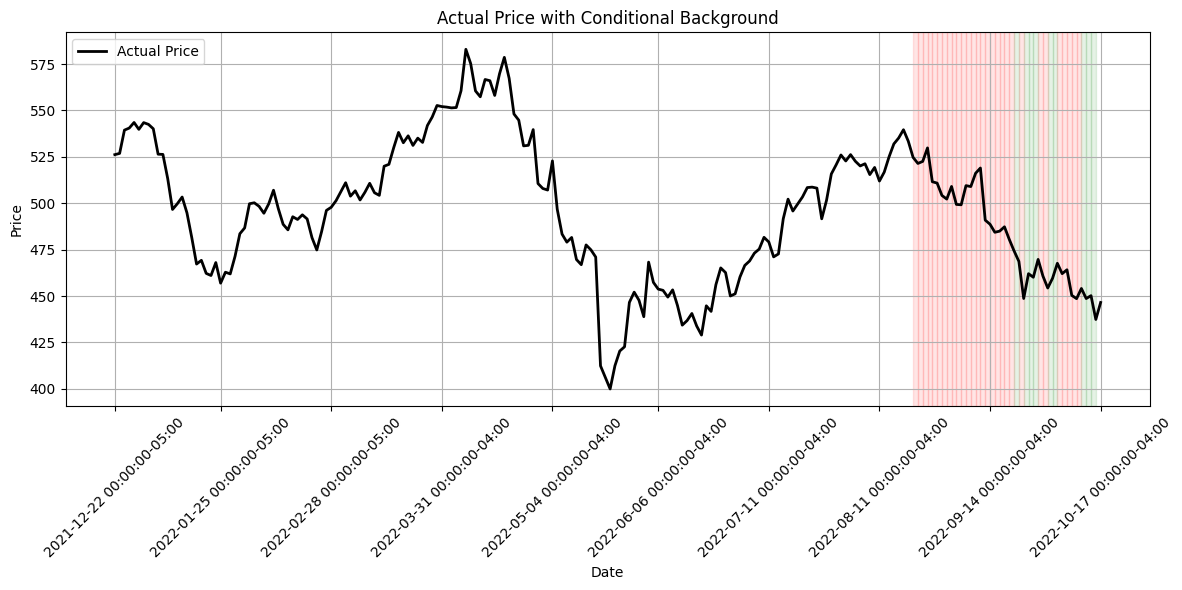

In [69]:
segNum = 2 # Change this when wanting to inspect another segment
train_size = 130
val_size = 38
test_size = 38

# TODO - combine all segments with bands? Just to get total visualization? PCA
plotSegment(segNum, train_size, val_size, test_size)

## Experiment: Average Returns over N Models

In [ ]:
numModels = 10
returns = []
for i in range(numModels - 1):
  # new splits of data every time
  X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled = splitAndScaleData(chunk_size, train_size, val_size, test_size, final)

  # new model
  print("Model ", i, " is training:")
  history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    batch_size=32,
    verbose=0
  )

  # calculate the total error
  pred_price = y_scaler.inverse_transform(model.predict(X_test_scaled)).flatten() # gets all the total predicted prices into 1D array
  #actual_price = y_scaler.inverse_transform(y_test_scaled).flatten() # gets all the actual prices in same timeframe
  X_test = X_scaler.inverse_transform(X_test_scaled[:,0,:]) #convert the current timestep into a 2D array
  curr_price = X_test[:, 2] # grab the correct column

  diff_price = getDiffPrice(pred_price, curr_price)

  gains = getGainSegment(diff_price, curr_price)
  print("Model ", i, " Gains: ", gains, "%")

  returns.append(gains) # append the returns on the end

# Calculate the average returns
average = sum(returns) / float(len(returns))
print(returns)
print(average)

Model  0  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model  0  Gains:  384.2387733922817 %
Model  1  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model  1  Gains:  363.7897169888258 %
Model  2  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model  2  Gains:  -49.933790918416335 %
Model  3  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model  3  Gains:  -24.727052374082415 %
Model  4  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model  4  Gains:  680.4779149435557 %
Model  5  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model  5  Gains:  323.780535119454 %
Model  6  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model  6  Gains:  -38.17575130468761 %
Model  7  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model  7  Gains:  105.2742452283317 %
Model  8  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model  8  Gains:  -13.277749851467412 %
Model  9  is training:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model  9  Gains:  210.27837581864097 %
Mod

So we have train, validation, and test sets, and we want to predict 5 days in the future throughout the whole dataset. so for all values, make a prediction, if guess > currPrice - max # of outstanding shares? - buy at currentprice and sell at price in day+5. Keep track of percentage profit of each trade, sum them all up to get a total percentage. if guess < currprice, dont buy.